# PTHA Scenario Reduction Tutorial  
**Weighted K‑Medoids + Coverage‑Driven NN Refinement with Elbow Detection**


This notebook is a **tutorial-style, self-contained pipeline** for reducing large ensembles of earthquake slip scenarios
in **Probabilistic Tsunami Hazard Assessment (PTHA)**.

We combine:
1. **Weighted K‑Medoids** → probability-aware representative selection (real scenarios, not synthetic).
2. **Coverage-driven NN refinement** → farthest-first addition of scenarios until a *coverage threshold* is met.
3. **Elbow detection** → automatic suggestion of a reasonable stopping point, balancing accuracy vs cost.

### References
- Random slip generation by Karhunen–Loève (K‑L) expansion ([LeVeque et al., 2016] in your uploaded KLslip papers).  
- K‑Medoids clustering for representative scenario selection.  
- NN refinement for coverage diagnostics in hazard space.  



## Embedded Inputs

For reproducibility, the contents of `scenario_pts.txt` (K‑L coefficients) and `scenario_prb_wgts.txt` (scenario weights)
are embedded below. This notebook runs **without external files**.


In [1]:

import numpy as np

# Embedded scenario points and weights
pts_str = """-1.042920688039620902e+00 -4.540369592190858783e-01 -1.751721096150335555e+00 1.433163281503105235e+00 -4.206245839632442030e-01 -7.925437723636098442e-01 -2.635373031771639063e+00 4.985909923801116750e-01 -1.383316941959827240e+00 -2.722783363693023873e+00 1.986781243666221775e+00 -1.796519484790793930e+00 6.984601514855042215e-01 5.328573691141007540e-01 -3.190077923875348276e+00 -7.573675078692803098e-01 2.208747289756731291e+00 -3.834404694946432102e+00 1.899403320086339386e+00 -1.096679330681195275e+00
1.094737101139178437e+00 -1.122941335954473097e+00 -6.234268279358526899e-01 3.338397177014834849e+00 1.180152480786234026e+00 6.191826360993324396e-01 -7.582401551946165164e-01 -6.732130551542943320e-02 -6.450674499018316244e-01 2.594597537551075028e+00 -7.714840354724877836e-01 3.323449812611946719e+00 -2.465932399265056585e+00 1.270562138141012598e-01 -2.536112539028650303e+00 -2.023240850110171074e+00 8.134295254921093676e-02 2.612249369222775730e+00 -1.891725638734412351e+00 -6.340459983690679424e-01
1.365409715527754253e+00 2.888090818240046875e+00 7.914898982893007195e-01 3.873655813490751720e-01 9.127348562425559031e-01 2.965108635562090811e+00 1.983645156011367927e+00 -1.672364028998631902e+00 7.527346557704758800e-02 -2.018294081822423536e+00 2.539306968030487166e+00 2.726782946933647422e-01 2.701550417360285561e-01 -7.315254638323016589e-01 8.221995950405622811e-01 2.272327463312523665e+00 3.369599282726381428e+00 -1.180843608774784920e-01 1.712804143951400793e+00 1.256406765187759955e+00
-1.484248346055485168e+00 2.961614679638279402e+00 2.110542357513317882e-02 3.689296534209278722e-01 -1.722014258885032234e+00 -5.488483492428918309e-01 -1.266685957793331374e+00 4.006668172288916363e-01 2.736979306362175901e+00 -1.918885486803436624e+00 -2.309724175266058666e+00 -2.659603278668007054e+00 -2.635049426655720062e+00 2.639245427107735242e+00 8.330011411031772450e-01 -7.328989027337645679e-01 -1.128234561350347276e+00 -6.507817572204043222e-01 -1.034918440405895312e+00 2.895087632230424646e+00
-8.121818884253145798e-01 2.257131337115616532e-01 -2.527951355655200683e+00 1.748128902039563393e+00 -2.829168176716252980e-01 -5.433118933446007964e-02 2.134754327888738423e+00 -1.053010992811568514e+00 1.599752399397694758e+00 -3.298070034125725858e+00 3.490215625958551282e+00 1.435952868115168091e+00 -6.171944747449297219e-01 -2.282407910660593675e+00 -1.009763779670452610e+00 1.276242401500256585e-01 -2.302665429053435187e+00 2.400294432836287406e+00 6.396184916905784945e-01 -2.053732565944422106e+00
-2.461773001698321084e-02 4.732480387893908680e-01 1.086360998764134056e+00 7.242148809591987257e-01 -3.368062251012343689e-02 -3.067736877053213629e+00 9.422254809709269541e-01 4.069511456351964540e+00 2.974595685568274028e+00 3.266332944478673728e+00 2.383116336156455795e+00 -8.045460759992476008e-03 4.088500047902563495e-01 2.596518911750949066e+00 2.062983505154305508e-01 -1.234359626309163849e+00 -1.871413929537491194e+00 2.204707627877962484e+00 6.898042210008595854e-01 -5.086007824734813942e-01
1.896532677146454793e+00 4.751130806009150609e-01 -2.170091619179089104e+00 -6.041015651093624150e-01 5.935859779261087876e-01 -5.946936473143467072e-01 -3.669229569616673015e+00 2.632203475513312352e+00 -3.779168010654730958e-01 -4.091182646365283393e-01 2.784927616486621904e+00 8.166601735621046299e-01 -2.376423138632160814e+00 1.926606366259193015e+00 1.546756519823524245e+00 2.096698844379298876e+00 -8.479507408716140393e-01 -3.858345688878767055e-01 -2.589872535524721631e+00 -1.707938862335708574e+00
2.490638201460576795e+00 -1.290107853075455502e+00 -2.014386513732982387e+00 -5.846149964297384649e-01 1.429579249610555491e+00 -8.943983341769404793e-01 2.398296571714020775e+00 1.395953131240637246e+00 -3.776701435686445674e+00 9.688172671189471119e-01 2.142315593961861442e+00 1.505406280290591425e+00 5.629487993676557389e-01 -3.628758392754556805e+00 -1.064121164318220902e+00 2.580711435198873804e+00 1.976819627175356309e-01 -3.945487860584434570e-01 -1.585876244232140575e+00 1.049320182317774047e-01
1.773886378620237014e+00 -2.650396335525729175e+00 -8.759467037562286285e-01 -1.086324040306120065e+00 -2.381576866115045821e+00 -5.308498662277055802e-01 -9.973163523509724904e-01 1.652310904979246375e+00 7.396334886213946636e-01 -2.415791043868533272e+00 -2.873010878519931754e+00 1.284896539764156242e-01 -6.511983969534472783e-01 2.250537726231895075e+00 5.965425893009912439e-02 5.697566273744271159e-01 2.672936208007907766e+00 2.662140884526673190e+00 -1.389871683223395493e+00 -1.926603432574176988e+00
3.426913421465282994e+00 1.613135724493697909e+00 -4.742736121880097300e-01 1.158937695305050752e+00 -2.141178391455157204e+00 6.161646232842314941e-01 -3.847130588653462913e-01 -1.026491852556660422e+00 -3.645044368009076940e+00 1.426209414294395961e-01 -1.461125157272439960e-02 -5.027090090406384215e-01 1.206009359097556910e+00 1.468393703283387142e+00 7.762705360056716408e-01 2.515721181507651671e+00 -9.553784910444759193e-01 6.630150189835442021e-01 3.534333821397510178e+00 -3.141183383502917925e-01
-2.188775424512305334e-01 1.810717501811201169e+00 -1.696147537940451366e+00 -1.706158956035708441e+00 3.597785445557884820e+00 -3.484804375764973372e+00 7.451528207114238578e-01 1.752025414832490968e+00 8.919562043102173821e-01 -2.241225813242782916e+00 -1.278646490061303265e+00 2.971199452993063872e+00 4.795740026286410274e-01 -1.716930318762890928e-01 -7.006973963726393917e-01 -1.848879016719957580e+00 9.851005367622999165e-01 2.003098743416936167e-01 1.298373278795959651e+00 -1.288016435604551813e+00
9.192402115812237096e-01 1.214291345065047656e+00 2.957777274931224554e+00 2.180862595752057764e+00 1.246998921996614884e+00 -4.386407757899078774e+00 -1.311512251400333451e+00 2.510675743699492202e+00 -3.335155480259534233e+00 -5.110754671595654219e-01 1.074608977376850349e+00 -7.386919489707529651e-01 4.089058263101859603e-01 -6.067921282860685439e-01 7.763722861131839847e-01 9.340423128845900536e-01 1.965733934856596754e+00 3.624476648473912849e-02 -1.049065125866764037e+00 1.337690840923939639e+00
1.225443242793133658e+00 -1.112416722452483242e+00 -5.886769729996050859e-01 1.746648642309921451e-01 -9.213126486635083712e-01 8.378089066609722968e-01 -2.898336461891746652e+00 -1.906408246573348064e+00 7.364631463878604789e-01 1.275273250418333948e+00 -2.031360132871221774e-02 -2.851866193015705431e+00 -3.418300977569410648e+00 -3.868191489129426119e-01 1.175571186208186104e-02 2.196361936639807055e+00 4.058636568423102275e+00 -5.413887878777244866e-01 -2.456351574280245753e+00 1.305037877306266247e-01
-6.755194003548007364e-01 -1.118774308414633323e+00 -2.100674615743494955e-01 -1.284453907090192137e+00 1.155845440369036338e-03 -5.867476232161878968e-01 -5.398916413688745752e-01 2.235117947281797690e+00 -1.344020979851801245e+00 2.551148605461366348e+00 3.186856485311376996e+00 5.460604118171223653e-03 1.463105494088825953e+00 -3.673793597656869192e+00 -2.076980530919788404e+00 -1.675229747556961302e+00 -1.916880240996732931e+00 1.176988108849511772e+00 2.351712339374250060e+00 7.024327512186171463e-01
1.810739659645225430e+00 -9.284441042002631317e-01 -1.184022778926615116e+00 -4.601119884094723389e+00 2.141220366914415862e+00 -3.902462920734220964e-01 2.738646250508798730e+00 -1.686131469611036771e+00 -1.351085514991038350e+00 1.968671535839458864e+00 -2.431876861770216613e-01 -1.480277754496359899e+00 -4.690546979916178083e-01 3.333503746431531578e+00 -1.701180433150349058e+00 3.349663497061419748e-01 -6.248942998878500577e-01 -8.657792223397497988e-01 6.922003969894583442e-01 9.007965492188229062e-01
2.746363639092704312e-01 1.600942672805953482e+00 3.073115523299200902e+00 -1.111205262663283122e+00 -3.504515764239059639e+00 2.770625239026801023e-01 -2.547530784350678257e+00 3.007166570417265095e-01 1.715637972877023243e+00 -1.173795137923776322e+00 1.611907856605980571e+00 -2.306668153839364965e+00 1.222474711651738190e-02 -2.072675824917029619e+00 1.741302167793156830e+00 -8.359349607958063144e-01 -9.359029060340875450e-01 -6.545719871863443506e-01 5.876429212336284902e-01 -2.600701190643366800e+00
-7.476603038962063852e-02 5.890256643150759697e-01 1.328831033715514032e+00 4.127739135441720109e+00 1.539653116910108255e-01 4.368554399211299621e-01 -4.176112420935386815e+00 -7.402685337082374195e-01 1.142481031599682728e+00 1.827252529453072150e+00 4.508475745334963314e-01 -9.245441496915514090e-01 1.502528614087995408e-02 4.069888587185628848e-01 1.122961262389768677e+00 3.204002827734422798e+00 -8.491574190097674890e-01 5.260013940883094818e-01 2.120463486697755862e+00 5.689963207932979827e-01
-4.673837277088046388e-02 3.551981854192984289e-01 1.295074725398262627e+00 -1.167250066365558725e+00 -9.450707926479258170e-01 2.760754660354416794e-03 2.619438928061496696e+00 1.686325454172730165e+00 1.653079638318579458e-01 8.065354884096794796e-01 -3.303378146814894278e-01 -5.821366600980855399e-02 3.610552059968640037e+00 1.812489038020384857e+00 -3.934150977536290950e-01 1.784646423786462099e+00 -2.336522056704634753e+00 -5.316642894358987625e+00 5.687307580340766888e-01 -6.172566104247459995e-01
-1.329312829157241138e+00 -3.831401029445750117e-01 -1.166350169524198677e+00 -3.761054257608176243e-01 -2.254462023903482937e+00 -8.065963863490518415e-01 -8.630115336182814234e-01 3.586941677834970310e+00 3.163030175026432800e-01 -2.297246215511500544e+00 9.760679914101703103e-01 1.274030617995893788e+00 -2.482989354641317092e+00 -3.013008681930749333e+00 2.139311880922564413e+00 1.577832158544816510e+00 2.367268605186668484e+00 1.028695114955134882e+00 -2.229410628539832684e-01 1.840116710420330426e+00
-7.290112569608445670e-01 1.885348226600744859e-01 -5.065282792411691659e-01 -8.661928747839077181e-01 -1.273884918436256619e-01 2.993700048670623337e-01 3.446361699588408878e-01 5.502165054214801510e-01 -1.903479081681439089e+00 1.175715581627946094e+00 -3.182409646338277831e+00 -1.913732922409987047e+00 -1.031385465873627894e+00 5.229615692904504565e-01 -5.389078864921177381e-01 5.943571054559877442e-01 -4.990866649937154342e+00 4.511778315931473493e+00 4.940258506102255809e-01 -1.155633875942096767e+00
-1.124234391012492118e+00 1.082595244442765781e+00 2.020982569844065602e-01 -1.137065566692751162e+00 8.460443822569921335e-02 -9.471750181743362473e-01 -1.365664540924193204e+00 -1.658143286260066018e+00 -9.237891479756757951e-01 -5.821608417085482046e-01 -1.183393410898212705e+00 -3.773056105814857730e+00 -2.329373371584254893e-02 -2.256855259670100367e+00 -3.437914277913557637e+00 -1.208316477971654646e+00 -3.248957948230579706e+00 -3.196378040819787270e+00 -1.053500404954773373e+00 -5.310365235339770118e-01
-1.260602842178581151e-01 -6.673318414658312436e-01 -7.176557389665441100e-01 -1.229455944047236571e+00 -4.461690933689650973e-01 -1.532760356366641652e+00 -2.685103607518663615e+00 -8.028546382345218557e-01 6.205501826109013352e-01 -1.006428790980798071e+00 7.054928574484197190e-01 4.541220899080963491e+00 1.978208855800764665e+00 -7.756951748499015808e-01 -3.243049771864872644e-01 2.620213720747905040e+00 -1.392578613132469334e+00 6.582834423786990685e-01 6.455083429228049008e-01 -3.475564441963827633e+00
-3.577923031214466643e-01 -1.890711187626000322e+00 1.598599402478587894e+00 -4.164206873069333653e-02 6.551523874623326194e-01 -2.499685152484002471e-01 -8.501523645477281343e-01 -7.725784284265738711e-01 1.673943480761767688e+00 -2.327125655713862429e+00 2.467230480659607039e+00 2.500129466662030620e+00 -1.894494302704459843e+00 -1.547311510761159248e+00 1.642662242063537503e+00 -9.576378362874274353e-02 2.270921154626533323e+00 -4.202222658950301337e+00 -9.941965994010959484e-02 1.761578319286144945e+00
1.086530831982383427e+00 -2.747483281248789933e+00 2.858429214421223108e+00 -8.409600758796524911e-01 -7.927411889382289800e-01 1.760866917002359200e+00 2.564111119619926882e+00 1.616878927500788432e+00 6.054572384124683460e-01 -1.333010823362993147e+00 7.055359447799518513e-01 2.760998156463041919e+00 3.193933993009490990e+00 -6.092427711287098369e-01 -7.448965733923539334e-01 -7.284824794083252231e-01 -6.380249836710817357e-01 -4.342297477687916407e-01 1.435453461640170847e+00 -1.757316917056571226e+00
-5.016049683279499405e+00 2.097982268998830779e+00 3.422374288676324761e-01 4.199751511828159756e-01 8.847776477389979188e-01 -5.873662732248450258e-01 1.889703401536670380e-01 -4.882656805613437845e-01 -1.670676396669661168e+00 -5.952475533168848365e-01 7.373756826675459397e-01 2.849406626366438822e+00 -1.036210233105674838e+00 -6.573993850307836562e-01 2.033376061696221093e+00 1.934550018416988093e-01 -1.412571555760814945e+00 -2.428425225312084823e+00 2.785625046640693547e+00 1.395071475591748156e+00
8.071179123901883745e-02 -6.928085302109338040e-01 3.652238258759655243e-01 -8.726483903613558857e-01 6.774173670113223800e-01 -6.564904907804857137e-01 -1.927957588688760382e-01 -2.113746514012601885e-01 1.688820654274574062e+00 2.205213892113511154e-01 -3.109510085716434280e-01 1.596431404876275995e+00 1.394091304452427904e+00 -2.846027987623741762e+00 4.891008853675432810e+00 -8.010033320386155120e-01 -2.086456829769450572e+00 4.439320533875715569e+00 1.595752063576786117e+00 -1.256422356665479079e+00
-5.544145022886015628e-01 -5.828363021650330156e-01 -1.400864302431026331e+00 -2.596791869599711644e-01 5.664004896978387382e-01 1.108664502386130346e+00 3.926417395459462778e-01 9.771233389841108563e-01 3.378115243517486821e+00 4.201001970165427202e-01 -4.364412684587407831e+00 2.294422196889193355e+00 -2.397227021790060864e+00 3.253234387830772789e+00 1.469604501926339513e+00 -1.734926171866481459e+00 1.618133387294143244e+00 4.064733147334785926e-03 9.787614140557250320e-01 7.186880579684458148e-01
-2.166283894041044211e-01 9.272624315576784293e-02 -8.818464973155487607e-01 2.362787757641542807e+00 -2.233576203951393335e+00 9.831004128295953715e-01 1.812138826466797692e+00 -2.312578803611970546e+00 1.680253537661815288e+00 1.247791928373492176e+00 -2.728430833382355480e+00 -3.444463043972326166e-01 2.510513768305631110e+00 -4.137157826935108140e+00 -2.007397039473331757e-01 -7.644336836188001527e-01 1.574034240223788572e+00 -7.958146360710337541e-01 -1.303629568115300286e+00 -2.055781358804953829e+00
3.037212110411867449e+00 1.267669154361463324e+00 1.872236442297722014e+00 2.888613712651620258e+00 1.310381653638929222e+00 -2.707912518305913174e+00 2.640123724972339048e+00 -1.395365901539871389e+00 2.081663447634657604e+00 -7.866761702758442998e-02 -1.580847636560724245e+00 2.154974911297357743e+00 -1.324511172139047899e+00 2.112625593256224121e+00 5.303531770261488143e-01 4.076725493740322448e-01 1.057374732405058415e+00 -1.298059836813481471e+00 9.644237484971107666e-01 -8.177705059851589908e-01
-8.229098934194364334e-01 2.506569790491058658e+00 -4.644740371054093764e+00 8.079016199473701976e-01 9.841821413654893158e-01 3.914203298741673276e+00 -6.652366665685847114e-01 8.128016333146956818e-01 -1.634101052060284776e+00 1.700403832850429398e+00 1.264490001681099152e+00 -7.920904261357653020e-02 1.281401177281327852e+00 -9.705361558090406376e-03 3.904072483239064417e-01 -1.669489425734549393e+00 -8.805867512150860055e-01 -4.691588695957234489e-01 -1.761897601723177165e-01 -8.399249519135685293e-01
5.071246989798741112e-01 -4.178929240999394445e-01 -4.471714784857966585e+00 2.365875591072144957e+00 4.993197259377081254e-01 -2.360418490010205428e+00 8.611912362663090015e-01 7.499098607579204323e-01 -1.774014164766192225e+00 -3.015755706000732839e-01 -3.447930899036825814e+00 -4.454456740853749985e-01 -1.059264033671639238e+00 -2.071571923667718362e+00 3.655625786984741388e-01 -1.306718517257076995e+00 -1.023817240633347447e+00 -1.542452427972060391e+00 -1.244135656968468506e+00 1.120492954406739683e+00
6.933824839308458943e-01 3.639854592138429545e+00 -1.667901422791191468e+00 -2.560986877683139706e+00 -1.123304893212646149e+00 8.516347333649896267e-01 -2.238504746608543261e+00 4.945896930251295065e-01 -3.393155136705083841e+00 -1.955173562726121528e+00 -1.507606559185290296e+00 -1.242844786983734018e+00 6.040989629071146227e-01 -1.919826663226220642e+00 9.868439968759924463e-01 -2.262344518122033854e+00 1.483501629565886049e+00 7.627850810239675816e-01 -5.659107370263020964e-02 6.464620568344510154e-01
-1.314280200842977031e+00 5.343785684832874638e-01 1.079276001926111839e+00 4.027813898276750293e-01 2.496944300167675213e+00 1.800238088795160563e+00 6.805743836705512029e-02 -2.969577035175408941e+00 -3.242413766892021654e-01 2.674782849248176664e+00 -3.650217238247419616e-01 -3.898431537121967771e+00 -2.566227020936149739e+00 1.008565097939071897e+00 1.797930124720986900e+00 -2.346617074569482764e+00 1.992598170662318813e+00 4.496834913737774442e-01 8.370861910072303624e-01 1.952184400367831696e+00
6.759421083580087197e-01 -6.508545128418007364e-01 2.462093387838273806e+00 -1.056823086035758807e+00 1.182651360048676104e+00 1.474968835421387459e-01 2.205032596419706614e+00 -3.480890743302857970e-01 3.689104748420332314e+00 -2.241001110940219032e+00 -1.414838186265474418e+00 -3.271310260347877197e+00 -5.620191591372507567e-01 2.081039576891713150e+00 2.766579013869867154e+00 5.783051851577039049e-01 1.723706328540181465e+00 7.392389058218282738e-01 -5.322109187066397240e-01 -1.107687534179960936e-01
-4.099933436420679089e-01 4.903838027021278356e-01 1.051334055591007344e+00 5.315722911193937472e-01 -2.479440718426493717e+00 -2.367535715799846230e+00 3.053200875534905823e+00 -2.064238794426299428e+00 -9.807010763546826215e-01 1.500634006121389641e+00 3.096128960158158971e+00 -5.871511876675605812e-01 -8.659134995342760988e-01 8.833467930133200030e-02 -1.052102170349208166e+00 -2.183121238333600722e+00 1.434189189277829346e+00 -2.386113839653503543e+00 -7.133206414226387349e-01 -3.167823605905063733e+00
-2.464590229045509062e+00 -2.705745270182005502e+00 1.013071999078665741e-02 2.885023397021149183e+00 -2.260510678774969584e+00 -3.763976134386421424e-01 1.405632609056923776e+00 1.532364819745467344e+00 3.333301383701176013e-01 2.192660980820360539e+00 -1.288802164750745494e+00 -1.842419743997995019e+00 -1.008195835235148191e-01 -1.889179879500725856e-01 1.723876182692633652e+00 -2.024872679605600023e+00 -1.788988472699046595e+00 -5.079456238399218115e-01 3.016259693699365751e+00 -8.646646269204768531e-01
1.285385127093755964e+00 1.686240005509189066e+00 -2.889760011628740966e+00 3.031359713645493059e+00 1.471921063843333988e+00 5.736453004404948874e-01 2.387966485015412310e+00 1.624252203272701145e+00 -8.618398417496829778e-01 -1.183440028292175983e+00 -2.984175037194938263e-01 -2.024453998441727354e+00 1.450457779603750996e+00 2.367540641806996415e+00 -1.341599592665983387e+00 4.545330860622235347e-01 2.087915695091256740e+00 2.217289062474356420e+00 -7.448264711874064137e-01 2.156039414909124430e-01
-1.897262867368578743e+00 9.270752515137588301e-02 1.426352881499903136e+00 1.827336674597439981e+00 1.429509434862326345e-01 1.153828754044906812e+00 2.150120330948780634e+00 -9.533688112095255462e-01 -1.008179100709995168e+00 -7.726887020904090742e-01 3.525106287228970459e+00 -2.055203498923987127e+00 -3.123044520139038216e+00 1.809738532801223876e+00 -6.828749493295056538e-01 -3.956312684666435930e-01 -2.534896006680011471e+00 1.060596771161875340e+00 -8.126112372259340910e-01 2.680865746063926913e+00
2.786025924760804795e+00 -1.117688926933112281e+00 -2.687686094592802166e-01 2.038831633398922705e+00 -2.942651652415417374e+00 2.242765596813166562e-01 1.072453116694247269e-03 6.820646599975669355e-01 -8.407370691369262516e-01 1.571690082966850532e+00 1.164590071027177487e+00 -2.169355370389673965e+00 7.299679559479040902e-01 -2.854412641709733300e+00 3.258097230285944557e-01 -4.870707852880084010e-01 -5.423226388036793688e-01 2.308111010038401911e+00 -1.129414634708925336e+00 3.792359072102028161e+00
-1.086649037304397325e+00 -3.354686871571099793e+00 -2.104990822041012399e-01 1.805747003532491846e+00 8.721508390415465550e-01 -2.850469182272668434e+00 1.749014708459025957e+00 2.322729531852865681e-01 -3.215582939463966561e+00 1.215084861123275406e+00 -5.908343165212080056e-02 2.513403688700501348e+00 6.919876272218158375e-01 2.282231440685918322e+00 1.839215661151501147e+00 -1.917126912620803481e-03 7.469484746350985027e-01 -2.118655952912884111e+00 1.619374924865952581e+00 -1.664728702709056540e-01
1.863690080577602437e+00 -1.790421445010233370e+00 2.314346076807729524e+00 -1.937311264072981043e+00 3.147615768050617685e-02 -3.089661276618178576e+00 -9.194304254356125972e-01 -5.111193861060158161e-01 1.735222947539382332e+00 2.887333017078812514e+00 -2.450644920727800713e+00 -6.547074583312209040e-01 1.669696398370383417e+00 -1.451294782053889509e+00 -1.931759894604062611e-02 1.740840240008328710e+00 -1.573275720874616423e+00 -4.249444962512686774e-01 8.287022389368705610e-01 2.829534025918471141e+00
-7.144973635996929584e-01 2.019860779297358189e+00 9.123961745217354924e-01 9.629106039592790767e-01 2.371969023632178042e-01 -1.375387164824159125e+00 3.165358868434210660e+00 2.551284075129884865e+00 -1.416133492946617167e+00 -3.328570585032132878e-01 -1.937088074606315491e+00 -8.596744923250436710e-01 4.055824128968291475e+00 -2.053001913368968090e+00 -2.268547996497184693e-01 -6.171458973107966095e-01 1.071029851220601570e+00 7.402067468150208551e-02 3.414607528343763798e-01 3.233406006737799654e+00
-1.124677113231020709e+00 3.916983346599265836e+00 -5.300766566105710176e-01 -3.098320352849102566e+00 9.504974657062448262e-01 -2.068744967982532046e+00 2.174387663731224052e+00 -1.429572133101915388e-01 2.353935065956767048e+00 2.004441002332959521e+00 9.234761614520684558e-01 2.553861682974425951e-01 1.269412482710533085e+00 -1.351430429972202418e+00 2.182088001495049667e+00 3.668772883200134838e-01 1.266213096107026148e+00 -9.755952672501145839e-01 -1.654314031319764622e+00 4.264617729202652696e-01
5.281198880125646811e-02 3.880079727686930324e-01 1.063016094811398471e+00 3.397776865563542636e-01 1.027514783441637602e+00 -2.720750644586821809e-01 2.757221123795018936e-01 1.448584734594198453e+00 -8.552577056722425741e-01 3.713900731317001824e+00 3.392774886855832728e-01 -2.551775510366859567e+00 -3.015507856019018718e+00 6.890147159026134283e-01 -3.089286970959221446e+00 -3.203247978307772748e-01 3.324654719102162481e+00 -3.036900347894913477e+00 -4.634865760350451169e-02 1.176394524271720199e+00
6.185176441545222614e-01 -1.067755993653516366e+00 -1.154856880327880031e+00 -1.567801970330114925e+00 -7.549291048851600738e-01 4.809982399135049880e-01 -2.814821987778827417e+00 6.025036292183245656e-01 6.099210116419554462e-01 2.528611300934110240e+00 -4.218004798708446246e-01 2.389173383558990338e+00 3.522668531611371723e+00 -1.285526449692612205e+00 4.546241435905489237e-01 -1.877595508272934755e+00 4.303144003364042014e+00 -1.735269016241962614e+00 1.954060272727483616e+00 1.272567685772501900e+00
2.499471564837943138e-01 1.039531089051328072e+00 -1.313116982667107413e+00 -2.660842055934076536e-02 2.506118603761316177e-02 -2.549869184989756121e+00 -2.918447113879508059e+00 -2.462279135933846674e-01 9.601193705955771707e-01 2.819290562428931057e+00 -2.055027171835941857e+00 -2.748839972041984048e+00 -2.379183438058278810e+00 -1.988446578254708719e+00 7.826887774037634138e-01 -6.074508360815493724e-01 2.936609586020435092e+00 2.433617144932640475e+00 7.923315339097797283e-01 -1.869156233527748290e+00
-2.984530045333304571e+00 -1.928582215246623932e-01 8.414649191233626313e-01 -3.624430909092259956e+00 -7.004835432137735962e-01 1.104209941190080535e+00 -1.864242261990932903e+00 2.134505129821926417e+00 1.066320798752401711e+00 3.935051285314420166e+00 9.873754978029886109e-01 -6.734738228924757042e-01 -8.402563997048453359e-01 1.551390798911985280e+00 8.851123155561563260e-01 4.647564655908202891e-01 -4.729258960850469262e-01 8.882081090103613463e-02 -1.478838599748128202e-01 2.597392158822398489e+00
1.890277247605423483e+00 -7.607382721869868636e-01 -2.660709259705226426e+00 -1.172736556426084764e+00 1.183461491078390937e+00 -2.117908856606209866e+00 -3.673224163461890623e-01 7.942995775412055037e-01 2.250608268385819954e+00 1.609452908939958515e+00 1.267126967857789666e+00 6.015203575501208710e-02 -3.222743938899488736e+00 6.556964213296397892e-01 -2.160536900723455833e+00 -1.326235863485650146e+00 -1.136627883892896484e+00 -3.442868845392366595e+00 1.377478819156203516e+00 -1.908693405619663608e+00
3.503278370067079539e+00 1.909765422373778110e+00 7.733120547637953868e-01 -6.857714064161398726e-01 -1.406120172760430664e+00 4.142765466715862543e-01 1.405701790606633361e+00 6.169220591107029208e-03 -9.748127696065655989e-01 1.527040273597581654e+00 -6.774050662936341727e-01 1.494285981180830947e-01 1.854035940480224465e+00 1.435724464541431544e+00 3.142835006017684840e+00 4.081314427847097109e-02 8.453281227429455813e-02 1.890770457646953506e+00 -2.774973826543396527e+00 -3.207387392783892732e+00
-1.782540244716467992e+00 -1.121949680418898199e+00 8.692173327715563280e-01 1.134702767814359303e+00 -2.638621407916454054e+00 1.101898795351316629e+00 -2.495693080550324794e+00 2.704966700911975996e-01 -4.163997072854791703e+00 1.637823290821468492e+00 -2.755204751002344299e+00 1.557591847299553800e+00 5.583204700741971616e-01 1.349134862455841910e+00 4.813049365411793401e-01 -3.745327751866858734e-02 -7.211746537834429205e-01 -5.959834235299131810e-01 -1.670076749778324210e+00 -2.012852937449078006e+00
3.574159955089170615e-01 -1.856197332668781674e-01 -1.205144825419426580e+00 -2.185545191502698881e+00 -9.855107740922347537e-01 2.526075286635661721e-01 2.036691600181646855e+00 1.466163037449773610e+00 1.923184303468407297e+00 -2.896131823557585694e+00 -1.017968865837177717e+00 -5.974047219119189844e-02 -8.314478326501819616e-01 6.964815090881817383e-01 1.115304194442898300e+00 -2.925152983888446467e+00 -1.794889278577801894e+00 -1.145090233217000847e-01 4.702631257112976471e+00 2.282318439157312362e+00
1.355891054099705728e-01 -1.678343364409658589e+00 -2.166348171435435788e+00 -7.570582679678856675e-01 1.297591378079732127e+00 -1.371783316041562450e+00 -2.368077718890514216e+00 -3.237906909066243788e+00 -8.063485376636805313e-01 3.474724810071263548e-01 2.122941627247310503e+00 1.406448795047998246e+00 7.212237059739800005e-01 2.832943776803144242e+00 1.326610407969460725e-01 -2.688708923812506590e+00 1.632920720482927912e+00 1.213165637561292920e+00 -1.162418863994264306e+00 1.929451876186421222e+00
-1.085816346373968067e+00 -3.281140688694192953e-01 1.049614810833805895e-01 -2.026695479926874377e+00 2.849922882440135918e+00 -1.389824438570066989e-01 -6.595858916529274696e-01 1.042983362610396592e+00 -2.414169120801644475e+00 -2.712528842851483546e+00 1.694328473975396099e+00 -2.275680129536129748e+00 -6.618416782225728934e-01 9.081575759947374538e-01 3.834186991027904723e-01 7.411450898199665183e-01 9.566162338115081765e-01 1.492111751490079241e+00 -1.102518323365845099e+00 -4.362873703736928732e+00
-3.036735474422863068e-01 -5.421603558601884032e-01 4.363355337089068198e-01 6.507051892944071270e-01 1.727678427531766925e+00 -2.409990351129969177e+00 -2.267017975035109156e+00 4.071152019647474307e-01 -1.314318015962208652e-01 3.467816933597869106e-02 -2.497857735468640872e+00 -2.482041130501932091e+00 4.877667064215192916e+00 1.836107707863064764e+00 6.243864441779130026e-01 -2.287248785129469386e+00 1.286208853782235151e+00 -1.240209689448361352e-01 -1.705444160435103940e-01 -1.763145793368259717e+00
-8.582663537954121624e-01 -3.466596484768377784e-01 1.828302511404134689e+00 -6.151861905201373437e-01 -2.329196961293249046e+00 -1.165732267020201496e+00 -7.648896736850835376e-01 -2.277058490541854052e+00 -8.084315231559791037e-01 -2.667220108711501947e+00 -3.023893577376674191e+00 2.473806564882163883e-01 -2.048725140480939788e-01 2.347117113300100755e+00 -1.096369454157892109e+00 3.931917381927541921e+00 3.568539145262946688e-01 -7.843025735807002130e-01 2.275524858758772861e+00 3.300244765607646347e+00
-7.887107780505957511e-01 5.324123953790889985e+00 1.652211720929822159e+00 3.625863681515853476e-01 -2.238319233941046704e+00 1.330310524213261125e+00 -1.474000964483446641e+00 -5.165169552018705063e-02 6.800090958374449546e-01 1.311056699624657540e+00 2.582023979958637527e-01 2.924596463932377599e+00 7.151353378338068945e-01 1.726581832589809240e+00 -1.937423418100774564e+00 -3.353304101339595888e-01 8.733502101253086680e-01 1.208464016638261862e+00 -6.012758266159765608e-01 3.546455306689386688e-01
2.360051746770227554e-01 -1.022699410953183063e+00 4.265504529336125450e-01 -6.749039275382459069e-01 2.505512043847160975e+00 1.450607560823261588e+00 3.694128908181608106e-01 -3.678599862621121819e+00 -1.250852548865880154e+00 -1.747850497207448450e+00 -1.677562081774631064e+00 -6.567623326865495992e-01 1.970922169896061726e+00 -9.565782117399467266e-01 1.836691500890310857e+00 -6.139141580915793428e-01 -8.582368670182669024e-02 -2.044118920189251121e+00 3.856079011599521156e+00 -3.196190931754050890e+00
2.417313630683717296e+00 1.465124397378816390e+00 6.725160554718083716e-01 1.732691334128368954e+00 2.175869215571920812e+00 3.706555594614002747e-02 -8.311679259914057649e-01 -2.683980132219556225e+00 5.896360174705632673e-01 -1.985269336538661444e-01 2.577241692735005696e+00 3.196565146149193404e-01 2.686918579230475945e+00 7.815848275103502996e-01 -1.584055082379428381e+00 -6.773696946816022413e-01 -1.735026005384014303e+00 -3.661744811301420377e+00 -1.446228600542474707e+00 1.518981957025277607e+00
7.405253076426145109e-02 -9.937713468236093473e-01 -1.305151625662053450e+00 -9.913420705235118646e-01 4.274833103587697414e-01 2.358144133286822763e-01 8.666004876353461395e-01 8.955158387628452399e-01 2.791052521175548140e+00 -2.087336346661286424e+00 -3.147271383403997813e+00 9.349833734805202967e-01 3.844809912362185056e+00 1.889721727940719243e+00 1.032744748624292885e+00 3.009173080720121796e+00 -3.591190406509675581e-01 3.545891533685609498e-01 -1.985179875230639546e+00 1.266074895325096428e+00
-1.306930300320958471e+00 -1.208198832239260501e+00 1.450107595501108904e+00 1.360339409629688356e+00 -4.570527887741897000e-01 3.956066869173042733e-01 1.139390913567839725e+00 -1.654631483022734217e+00 8.949999681543038266e-01 -1.893643921341410907e+00 2.895679720797315060e+00 -4.641107688156758670e-01 2.333245006146417388e+00 -7.034444660540867256e-01 2.701163545052817305e+00 -2.383754349716981746e+00 -2.382919239067678718e-01 5.622818466301684470e-01 -4.122286509915310759e+00 1.747198719893293672e+00
-1.107334981851423761e+00 1.221971385079889005e+00 5.608808294386810056e-01 -1.000722653135050350e-01 -1.956489242686521912e+00 6.019836337505711787e-01 -2.071421697447970889e+00 2.196692951316109088e+00 1.656918777786748898e-01 -1.370580922766988730e+00 -1.855592833078204829e-01 -9.839745074720620543e-01 2.869584004921275966e+00 -3.044440603741280782e-01 -2.512925716641669194e+00 2.671993609607642206e+00 1.368343704882338807e+00 -7.355798755523415000e-01 -4.389343561152296402e+00 1.478807481421777315e+00
1.667347043206625079e+00 1.068061472230219522e-01 1.977845644185054708e+00 -2.409212218222244739e-01 1.229966087389589013e+00 4.059306865729075398e+00 -3.557931433695149970e+00 7.919692198290639862e-01 1.383118949592745173e+00 -2.733475563003664011e+00 1.651616629057204855e-01 -1.921145517948849579e-01 3.472475547418596986e-01 2.453992522589776293e+00 -1.244513644168454114e+00 -8.497194962220191439e-01 -5.420402963249151829e-02 2.009732047207594796e+00 -4.236344695013397055e-04 1.123606691836722460e+00
8.361246051307291705e-01 9.933529031548531119e-02 -3.872247861921329637e-01 -1.393584118950460971e+00 3.230511590367197261e+00 2.981004183489996517e+00 8.192184768495552882e-01 3.361950643934600969e+00 -2.327666421168946176e+00 3.697753515866854523e-01 -1.032348821919757631e+00 1.278776740935105849e+00 -6.381726941439155310e-01 1.006465569993667541e-01 2.697185711056798496e+00 1.348869414662062116e+00 4.342230600081600778e-01 -1.651217802153549519e+00 -9.392279554183836643e-01 2.168472174549611164e+00
-7.532020893158658525e-02 -5.017132588012380712e-01 6.171069465036544965e-01 -1.269818816997532629e+00 3.048677695327620008e+00 2.206730215336351719e+00 -2.216573303295378050e+00 -2.471096781719136715e+00 2.537942860447985893e+00 2.154543807466721361e+00 1.270930663631038460e+00 1.508073112228855095e+00 -7.307683767563145638e-01 -2.010687073402195768e+00 6.291937494921608920e-01 -1.538126897973779217e+00 -2.194760822535293254e+00 1.146534411533119413e-01 -2.694645586323236142e+00 -1.353837592660278588e-01
1.319306683027966720e+00 2.006975710740369845e+00 4.729215392233820925e-01 2.331441521636347325e+00 -5.815317094693350786e-01 -7.527070783290766842e-01 1.427195182871350942e+00 -6.167269972245620346e-01 2.473986488738044165e-01 2.147932602272134783e+00 -1.976747891240256128e-01 1.361455547324171400e+00 -3.106620528709830964e+00 -2.362208677732684947e+00 2.547963192433472024e+00 1.944452766599245264e+00 -3.949676929757421018e+00 -7.192796862429244875e-01 -1.170545625669120016e+00 -3.249034794592400854e-01
-1.227060812587300820e+00 -2.297549814215529840e-01 -1.085766983364661487e+00 2.361320946278126609e+00 1.083927460344385335e-01 -3.994385995349344576e+00 4.582467477940364020e-01 -1.468433440828764702e+00 2.165845133254107324e+00 -3.515353433945734296e-01 7.090566173443891840e-01 -9.747963375773593953e-01 -3.108751923493003888e-01 2.088553980893915085e+00 -3.230869119977576975e+00 2.212854977707686910e+00 -1.118161741157188693e+00 2.398907161946166600e-01 -2.348891361978620917e+00 1.258927471951907684e+00
-7.655890694469564828e-01 -1.263939149801343031e-01 8.856681858567286847e-01 -1.880279840250115075e+00 4.629855167714438391e-01 4.219681219847181142e-01 -8.180680688347509166e-01 -2.490753764762952738e+00 2.892569374237320634e+00 -1.401312513389896708e+00 -1.559662308257138141e+00 2.920683298945300210e-01 -1.307552723232505154e-01 3.294862674079929388e+00 -9.669152364269791022e-02 -2.852328770922414769e+00 -1.654195245389741720e+00 -3.059331797184552837e+00 -1.599186033617068681e+00 -2.907833824181986326e+00
8.988145241450577749e-02 8.095073982827435399e-01 -2.784821606374499048e+00 -5.247348501414398347e-01 -5.139867088762550829e+00 -3.971318603283879312e-01 9.003574284870198285e-01 -1.349306750596255267e+00 1.276622211827636244e+00 1.182717172602548716e+00 2.420234771252344430e+00 -4.771266333629946010e-01 2.246241364048065847e+00 1.796402624462009490e+00 4.650424282122731512e-01 -4.297277038399669596e-02 7.605045939050955051e-01 -9.242445211909120495e-01 1.065911838758033081e+00 1.971426094226999215e+00
-5.848549818511042941e-01 -1.878961526248689395e+00 -6.824003826063700373e-01 4.716483881421827951e-01 4.273867635430099177e-01 3.836666206612552976e+00 -1.701503656393665409e+00 -3.340498683320484163e-01 1.035369655030849989e+00 1.888542347230529161e+00 -2.558645028071405481e+00 -5.454980550789295668e-01 -7.800189109796506863e-03 -2.383379860266590100e+00 -3.264888628382572655e+00 2.006797903621194479e+00 -9.932214264514363511e-02 -2.253296898994711306e+00 1.803756304100425645e+00 6.979147385992278130e-01
-9.222764565550483074e-01 -3.157991600333623361e-01 -1.042177939738594405e+00 1.542826784088807246e+00 6.304621168943760345e-01 2.915059028669887198e+00 1.605761325141035423e+00 -6.917203275325821688e-01 1.706959982344563587e+00 -4.145906343773540392e+00 -7.861475724993244318e-01 1.691356656568571593e+00 -1.053231711873461318e+00 1.539577346695984339e+00 3.536546758129471835e-01 6.660538021379130980e-01 -4.465894639215502337e+00 -2.302074070925523408e+00 2.994857645115916456e-01 -8.932826430064589457e-03
-2.993873805720945191e-01 -1.208528559666714047e-02 -1.654921672952290243e-02 -5.712356480842962769e-01 -2.315962656076326009e+00 4.012762723779647267e+00 2.152583183606548545e+00 2.769678807303424861e+00 -1.010729668914795709e-01 5.576345397706179430e-01 9.026162682496654543e-01 2.676358605887845798e-01 -3.178276877541744483e+00 5.218630973011242347e-01 -1.893283775042125638e+00 -1.432006357812626307e+00 1.590841619162711496e+00 9.152079669211170554e-01 2.417792493650254393e+00 -1.701368465072585323e+00
1.365669242995448007e+00 1.390921368900464916e+00 1.442047174745606508e+00 -2.128834454721314717e+00 -2.129485698204911071e+00 -2.895372607760220873e+00 -9.738578645511868359e-01 -1.769427710804279963e+00 -1.551273341630069469e+00 -7.250019524582111963e-01 1.587273268964317641e+00 1.635686964624494255e+00 -3.920182576746839231e+00 4.265858580514845233e-01 -1.064617098412801166e+00 -7.798343698543310776e-01 8.538917269615532712e-02 1.979663321413173804e+00 2.680356512702743110e+00 -5.156465172623003745e-01
2.398749682287001639e-01 1.909037760723666821e+00 -1.114930463464088861e+00 -4.933437150672410204e-02 -3.356632191283752231e+00 -1.362233031767452918e+00 2.231671715143537238e+00 2.057741730875868591e-01 2.646119078671098079e-01 2.422948938760256077e+00 -1.997276745365685668e+00 -1.113097060408331451e+00 -1.189775192853081531e+00 -2.252825205553518284e+00 -3.491180007999948209e+00 3.463666555328383634e+00 6.474137372566665660e-02 -5.110298197819649335e-01 2.457402761329475549e+00 -8.215714832046578930e-01
-1.089772200692231685e+00 1.656882960040633457e-01 6.838673498595082556e-01 2.415098909257638482e+00 -2.483686231795220856e+00 -9.829243064120333218e-01 5.452333982360885178e-01 2.872234523806607709e-01 1.447691407757486948e+00 -3.422030251614687213e+00 1.525637839854739886e+00 2.725777575231202121e+00 9.559371648072999550e-01 -2.196273292329940785e-01 -2.737296106996383926e+00 -3.439961185281094291e+00 1.148094554344708973e+00 1.764041943693454906e+00 4.144153160182569851e-01 9.184400335236452273e-01
5.124632886063376080e-01 -2.239218150730022394e+00 -2.932759853684708151e+00 1.321319610440346404e+00 1.397569633123239230e+00 -4.278221252144073228e-01 1.947897243928026656e+00 -1.769754263044013509e+00 8.266913499544390476e-01 2.965302289299600158e+00 2.561071481344527889e+00 -1.368666835009368032e+00 -1.461865684968900458e+00 6.131896000443711747e-01 1.922199514801282927e+00 2.541680842816025354e+00 2.688909723480359393e+00 -1.103409466238839842e+00 2.534175428408645292e+00 -1.325447067621532193e+00
-2.224838235271651143e+00 -6.742448221457207451e-03 -6.381255202784292813e-01 1.228189939773987716e+00 -2.372259105067744844e+00 5.922504570550142233e-01 4.323649877491350102e-01 4.479981130328916650e-01 -2.880813659691198736e-01 -1.370252623165185479e+00 8.728225292156923665e-01 1.496560596134612897e+00 -5.279941303189015223e-01 4.029578456056965408e+00 3.673313226769279627e+00 7.937028678559187034e-01 3.462348686031750500e+00 1.938080986097812763e+00 6.005438953819563358e-04 -1.631159789454346365e+00
-2.620781557417006802e-01 7.357596179082773746e-01 -4.486589096055492720e-01 -8.901795204594634692e-01 1.089872868536177819e+00 -2.187860397667560353e+00 1.262225313321244213e+00 -2.153064614568001911e+00 -3.248870576475714866e+00 -2.620333317254997851e+00 -3.006535167830316491e-01 4.818847540731671653e-02 6.531542873018657547e-01 -9.950747211567027017e-01 2.807696914531665477e+00 -2.662436249646794595e-01 -2.891185452499639208e+00 2.050809959473783195e+00 -2.370672691624363004e+00 2.670694369793776168e+00
-1.756088576431639625e+00 -1.118588165823773073e+00 3.274885615083632739e+00 -2.007469290299671361e+00 -9.604627215887249214e-01 -4.325777485628845564e-02 4.326181073146631029e-01 1.826146751161444870e+00 -2.149156596149043530e+00 1.861355127252273700e+00 2.645995430082857425e+00 9.195398275254667020e-01 -1.604737188854388430e+00 -2.158653351946119958e+00 4.165173711801438694e-01 3.859767851699140273e+00 -6.918225843405144682e-01 -1.806529198695228655e-01 -2.342777608276452206e+00 -3.978926924191297787e-01
2.148022884398038013e+00 1.685023341630161597e-01 -2.050713942892890440e+00 2.078816968574856983e+00 -8.032988492963015759e-01 -3.382284931681376339e-01 -3.116512100666124052e+00 -2.911496791683319874e+00 2.318575206298338021e+00 -1.264391235057698903e+00 -2.734417813775047446e+00 1.512958923252689658e+00 5.874978194577152868e-01 2.183576002031103469e-01 9.217254028365416962e-01 -2.950097938769136174e+00 -2.413058623116721702e+00 -8.683730496894559447e-01 -4.893851605596900023e-01 9.692102520592108528e-01
2.838346489244231385e+00 -1.279105269696460656e+00 -1.329078583248700873e+00 -9.144186134202397787e-01 1.389776504973895488e+00 -1.432314399838046370e-01 1.672838334622182899e+00 2.138433926938881346e-01 2.111106255975443435e+00 -2.333903017237986433e+00 1.206520381926331931e+00 -3.196682604043186160e+00 -2.021407385800737977e+00 -2.246336884963993530e+00 3.851209644139970689e-01 -3.403920594226780505e+00 1.511544092985814443e-02 3.982807994447211675e-01 -2.107319905649162273e+00 -2.838968471657898340e-01
3.139873727501935607e-01 -1.590488983858745264e+00 1.773339949721526310e+00 -4.924991029688747246e-01 -2.775225815252531092e+00 3.258529854766964551e+00 2.322990954004239050e+00 -9.051745431804910647e-01 -2.529168309517635826e+00 -2.342415903809335287e+00 -5.162113867129675127e-01 -2.099227213544888837e+00 -5.908993488758896850e-01 2.096236219545070112e-01 -4.634704339126020090e-01 -8.479945138640564428e-01 1.906879260688834898e-01 -2.525953777312807347e+00 -2.242366188657222814e+00 1.108583346610521270e+00
6.131732584898191146e-02 -2.967785380406411933e-01 1.666443317544524350e+00 -1.854701036962306926e+00 2.353385353708230543e+00 -3.751196519498928988e-02 -1.637564694872001292e+00 1.351610030966172715e+00 -2.168124175171242562e+00 -1.653671983331469697e+00 2.977581148221181362e+00 -2.385313415591574504e-01 2.694627926759113112e+00 1.937405304413031493e+00 1.065992222434728687e+00 -9.105496451640262556e-01 -3.706602594241133364e+00 1.061943167242651143e+00 2.033310684430296611e+00 3.524098183586437116e-01
-1.906674995279432849e+00 -1.388912296767047527e-01 1.912108195139993638e+00 9.721631653233432369e-01 7.515387473933038409e-01 -4.114125284514688063e-01 7.741474982250147185e-01 3.005582584158348336e+00 4.055820207698218383e+00 8.977484865064108144e-01 -1.391114562390946441e+00 5.373467663874671729e-02 -4.803292593270118149e-01 -2.028249099818361767e+00 -1.107129494136402936e+00 1.454188693241718289e+00 1.163411204926037890e+00 -1.217445584786955637e+00 -1.292958968292812427e+00 -3.884346307000764220e+00
-1.061814350900293968e+00 3.641346361973902268e-01 -1.861650311031485039e+00 9.950326719039368495e-01 1.077695203186022743e+00 4.143939896512498500e-01 -4.549251575578294182e-01 1.467067784520597495e+00 -8.511478108876206761e-02 -1.025812341476183054e+00 3.980510823642277596e-01 -4.556328878076201683e+00 -3.466136618375496581e-01 -1.768338938654155923e+00 3.326711464529314544e+00 1.047488184241563758e+00 -3.026493473963077996e+00 -1.483022713660432590e+00 -1.765378778733361020e+00 -2.299786039416405803e+00
2.340943844669659823e-01 -4.696027327584373912e-01 -3.701166916695888126e-02 2.767371402219763188e-01 1.954617176259901168e+00 1.605244915167750364e+00 -1.584729796486765485e+00 -2.798082237889521817e+00 -2.020974009129279825e+00 1.263466506876002482e+00 3.021248721291999839e+00 1.195823177454889530e+00 1.706648078183795603e+00 -3.290021834135470336e+00 -1.032155907113487148e+00 -5.609332622192407802e-01 2.922313433712295350e+00 -2.982985121259881800e-01 -1.599499637571300870e+00 -3.646905487250647671e+00
1.960600112975039999e-01 -1.336272572483869769e+00 1.931239415085078903e+00 7.711522565758073267e-01 -1.080559630528703963e+00 7.189678735538040932e-01 -2.074131446195345951e+00 1.352734569371137674e+00 -1.770314129646741064e+00 -1.318602309421698315e+00 -2.922145539935684155e+00 -1.248331433422372738e+00 1.563186774559124081e-01 -2.152527065045931387e+00 3.085177348887619964e+00 -2.179297301501980311e+00 1.754332788268516907e+00 1.499753010762374883e+00 2.353390194543300673e+00 2.039034599932059155e+00
-3.946273725750674366e+00 -2.559129881931434980e+00 -2.282833802596615058e+00 -2.806100973583744551e+00 6.670327695606198537e-01 1.070893289345884680e+00 2.108579762972091487e+00 1.426118595599187078e+00 -1.028275385443538470e+00 -7.422342063373051912e-01 -1.299844090244583472e-01 1.947648875565875515e-01 -2.394659169171093616e-01 -4.726001611936134911e-02 -1.941916643452644475e+00 -3.757573917898162086e-01 2.061221980602262249e+00 1.478391005376017864e+00 -1.310569692681133658e+00 1.582293083790506261e+00
-2.388163755659903131e+00 -2.993061138139344601e-01 8.194422770238114773e-02 1.682213736377279334e+00 1.603645805253950174e+00 2.134092816830418737e+00 1.787116476175423019e+00 -1.525101362019045004e+00 -6.596084375993239990e-02 3.606517837824062767e+00 4.569384659229054346e-01 6.755690595359955530e-01 2.552062849927892341e+00 -4.327210378408866687e-01 -2.081605484855144350e-01 3.607081612987417599e-03 -1.085334341675377734e-01 3.880177329995515567e+00 -6.596076373313666252e-01 -3.307379397004768684e+00
1.986705953000614366e+00 -7.184477036993700549e-01 -7.551350576790738511e-01 -2.557316107561281360e+00 -1.396146499218363424e+00 2.729614530893929025e+00 -4.138004347866217625e-01 -3.347672449499260683e+00 -7.646116427006371952e-01 1.211429571085798518e+00 -5.565624931566751643e-01 2.669428437110197283e+00 -3.178955652314077618e+00 -1.549976280276203822e+00 1.932136797715528598e+00 8.732840186562589313e-01 -6.140794663604355330e-01 1.498489456526886643e-01 1.371835630179478294e+00 2.260556053376562513e+00
1.653177614812564755e+00 1.084829324642090143e+00 2.563478185109616003e+00 2.080112348788058507e-01 1.390048666901148033e+00 3.183601993970293087e-01 1.955711077675692744e+00 1.393995471093798288e+00 -1.047311246444915245e+00 3.113777007197823465e+00 -1.332459117717634145e+00 5.358897417847993117e-01 -9.849900658608007342e-01 4.995979975389726047e-01 7.862386923680073636e-01 -4.764683970871482543e+00 -1.246341275712957497e+00 -1.999901232043157506e+00 1.632778343589252446e+00 -1.191397165538331748e+00
-1.075549561924489694e+00 -6.490878887538823472e-01 -8.045309155358524311e-01 -4.804173917228686808e-01 -1.797052906172612818e+00 -1.316436030498005838e+00 9.843401148901840259e-01 -1.417961100353047010e+00 -1.233040870770615166e-01 3.285876728337488561e+00 -1.198781508403178320e+00 3.897297930828018675e+00 -7.414344692265351089e-01 8.443542205478536955e-01 1.132992803477441024e+00 1.800781373506051275e-01 9.884056975114406673e-02 -2.659194665162089244e+00 -4.212134789807831403e+00 1.634926555865373832e+00
5.058716388183696067e-01 -3.526728449713910085e-01 -1.353094868919042237e-01 4.400048921142124536e-01 2.293040027815180348e+00 -2.093844042960159024e-01 -9.338743240944029633e-01 2.205305878889154858e+00 2.467883900364735261e+00 -2.506245263290651337e+00 1.715489639319753179e+00 -1.284475415740439219e+00 2.099284250105440286e+00 -3.483873407954547918e+00 -2.996262173993609057e-01 2.609632297552364921e+00 5.013412564942184430e-02 -8.196881479917388358e-01 2.760950344708622328e+00 1.478448200964137760e+00
-2.268934282198551700e-01 1.209375854216225621e+00 2.245466901681036020e+00 3.288188851184699613e-01 3.343902600801631486e+00 2.056567136292058451e-01 1.827367762190759803e+00 6.119324727902408778e-01 -2.856526366252129634e+00 -1.205213739303949483e+00 -1.862367077422202755e+00 1.458293044771119984e+00 -1.322661061084267731e+00 6.546984372120890905e-01 -4.039262026724817822e+00 2.906274864235957711e+00 -1.478228188120990882e+00 3.144407974631766023e-01 -9.719630579511259194e-01 -8.864605672518399704e-01
1.527444489644189440e+00 -4.609021799071381764e+00 2.116396431546561985e+00 1.817130101137605758e+00 1.307660944378949308e+00 -1.245610808904902278e+00 8.108362439055217807e-01 -1.258454947345718944e+00 -1.121380685360334972e+00 -1.799029387455973739e+00 -3.955404916265929938e-01 -1.543805825785269370e+00 -2.072130964759971050e+00 3.888189567754011255e-01 -1.168409522726037819e+00 5.115764852707468391e-01 -4.459117687167561961e-01 1.943663631406234327e+00 2.533834086857471135e+00 -1.094264927544014609e+00
-1.579797672371378914e+00 1.131195252876094903e+00 9.409990013522026020e-01 2.830716757233738612e+00 3.009954226982820114e+00 -2.704762751088869988e-01 -8.193424291046748076e-01 -2.178041057312266326e-01 -1.779690690882661297e+00 -1.149752025200862171e+00 -1.199280731614684736e+00 1.614400391863457240e-01 -1.494878842724558288e+00 -3.451338756725844448e+00 -1.823240078725294921e+00 -1.920578363128152777e+00 1.517947934872803550e+00 1.917121902563861502e+00 4.963840045456900385e-01 2.414047809252244825e+00
-2.921544840804632948e+00 5.434016815661102395e-01 5.971157189198939008e-01 -1.890371701737929566e+00 3.088064190223976380e-01 -3.490034904774836910e-01 -1.407987680860280366e-01 -3.591391348378258019e+00 -1.211266482736270467e+00 1.114232182740251265e+00 8.784768484920363329e-01 -2.159783160149274295e+00 2.450046633769070059e+00 7.965361771080106124e-01 -2.726730922326785489e-01 2.994642444744044063e+00 4.648597339746249890e-01 2.651306966876629367e+00 2.191830272208040498e+00 2.603881300764426809e-01
1.293324378119280693e+00 2.196211070966313517e-01 2.372694804169233063e+00 -2.935655499550001046e+00 -4.257355359820081397e-01 -6.913422536823393694e-01 3.043905106672159522e-01 -4.320342368586929660e-01 6.784257870682883773e-01 5.606736991628707978e-01 -2.308873145573949515e+00 1.041157784209357784e+00 -2.192799852304040398e-01 -2.402322240572106082e+00 -3.636179355904596289e+00 -1.847966128450760692e+00 2.327294431269322783e-01 2.715951361412052290e+00 -2.526559764225204674e+00 1.902216886723987477e-01
2.120523746037925150e+00 -2.677769247772342265e+00 1.145707236516630423e-01 -5.440491262449564935e-01 -1.862614629312939973e+00 1.958334395541512229e+00 5.050402150056904071e-01 -1.643550666359205881e-01 2.141624953989181623e+00 1.868566607107152722e+00 3.061580127515080907e+00 -1.217679121558652433e+00 7.298924093143361880e-01 2.255391775777235708e+00 -1.979039596106043852e+00 1.279307193156978828e+00 -2.326664826243009632e+00 2.265679640995649446e+00 -1.280887282603533572e+00 -2.100690703126898984e-01
-2.113750936721375817e-01 2.176783226344233491e+00 -1.023297616270314681e+00 -7.389485711320837868e-01 1.165002468660560453e+00 1.523953117950126224e+00 -7.589249097912876829e-01 -3.730289945097468696e+00 1.912928206460753788e+00 -2.421976211632413278e+00 -2.943853258837251019e+00 1.413788293056756462e+00 -9.233903418958436804e-01 9.329311896906763435e-01 -2.011279540576362823e+00 1.621160767769539435e+00 2.538808186961118540e+00 1.828300402208766551e+00 4.737209785450413602e-01 -2.977484169840140638e+00
3.882782349264891630e-01 -4.945644565519596858e-01 -1.180369146593512886e+00 6.532835658033512294e-01 -5.955138531481721786e-01 -1.052698549964148134e+00 -2.375919920778479799e+00 3.830095568525996974e+00 -5.358173650967433810e-01 -1.133535352166943122e+00 -8.217775715677004822e-01 2.823930388872368358e+00 7.695162176662240228e-01 1.560750977361475389e+00 -2.884859000963443609e+00 -1.885565076802618312e-01 -3.725152329820479835e+00 -8.308662190199702646e-01 5.350169022325027557e-01 2.326169919874259140e+00
"""
wgts_str = """3.829333333333333460e-03
7.255333333333333252e-03
1.480666666666666589e-03
5.244666666666666574e-03
6.699333333333333182e-03
1.152599999999999979e-02
6.246666666666667077e-04
7.680000000000000195e-04
2.912000000000000092e-03
4.821999999999999897e-03
2.866666666666666777e-05
3.133333333333333375e-05
9.201333333333333933e-03
3.293333333333333529e-02
1.666666666666666747e-05
8.799999999999999771e-05
8.600000000000000331e-05
1.648799999999999918e-02
1.277599999999999916e-02
1.230906666666666677e-01
3.015866666666666696e-02
3.608666666666666707e-03
2.185399999999999843e-02
2.953333333333333201e-04
1.493333333333333221e-04
7.865066666666666040e-02
4.670200000000000046e-02
7.381333333333333496e-03
2.333333333333333242e-05
6.000000000000000152e-06
1.206666666666666678e-04
2.979999999999999793e-04
5.825333333333333405e-03
4.429333333333333733e-03
4.533333333333333117e-04
1.279999999999999942e-04
2.759999999999999867e-04
3.227333333333333356e-03
3.067999999999999981e-03
6.386666666666666143e-04
4.979999999999999618e-04
2.257333333333333414e-03
5.399999999999999798e-05
1.245933333333333337e-01
4.430666666666666954e-03
1.786000000000000044e-03
1.113333333333333335e-04
3.002666666666666505e-03
3.967333333333333129e-03
8.873333333333332899e-04
8.770000000000000018e-03
1.566666666666666728e-03
2.853333333333333156e-03
3.725333333333333535e-03
1.196266666666666659e-02
2.400000000000000061e-05
9.788666666666666002e-03
4.897999999999999576e-03
4.101733333333333620e-02
2.709533333333333238e-02
1.579600000000000101e-02
5.000000000000000240e-05
4.513333333333333173e-04
1.920000000000000049e-04
1.302466666666666703e-02
8.739999999999999939e-04
2.499866666666666556e-02
3.333333333333333493e-05
1.123333333333333389e-03
4.113999999999999602e-03
8.293333333333332896e-04
1.113999999999999973e-03
1.265999999999999981e-03
6.732000000000000137e-03
1.320666666666666603e-03
7.934666666666666257e-03
2.028733333333333430e-02
1.014666666666666755e-03
5.006666666666666210e-04
4.662666666666666522e-03
2.320000000000000014e-04
2.237999999999999972e-03
1.230999999999999976e-02
3.403533333333333410e-02
1.586600000000000163e-02
1.436933333333333292e-02
3.066666666666666895e-05
1.098666666666666628e-03
2.579999999999999828e-03
3.105999999999999820e-03
2.328600000000000114e-02
2.504466666666666647e-02
5.033333333333332802e-04
1.060000000000000016e-04
9.053333333333332938e-04
4.406000000000000194e-03
4.309333333333333418e-03
4.500666666666666704e-03
1.867399999999999963e-02
2.559399999999999870e-02
"""

pts = np.array([list(map(float, ln.split())) for ln in pts_str.strip().splitlines() if ln.strip()])
wgts = np.array([float(ln) for ln in wgts_str.strip().splitlines() if ln.strip()])
wgts = wgts / np.sum(wgts)

N, D = pts.shape
print("Loaded", N, "scenarios in", D, "KL dimensions")


Loaded 100 scenarios in 20 KL dimensions


In [2]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Helper functions ---
def pairwise_dist(X, Y):
    X2 = np.sum(X**2, axis=1, keepdims=True)
    Y2 = np.sum(Y**2, axis=1, keepdims=True).T
    d2 = X2 + Y2 - 2 * X @ Y.T
    d2 = np.maximum(d2, 0.0)
    return np.sqrt(d2)

def weighted_kmedoids(pts, wgts, k=20, max_iter=100, seed=42):
    rng = np.random.default_rng(seed)
    N = pts.shape[0]
    # init
    medoid_indices = [rng.choice(N, p=wgts)]
    for _ in range(1, k):
        current = pts[medoid_indices]
        d = pairwise_dist(pts, current)
        nearest_d = d.min(axis=1)
        probs = wgts * (nearest_d / (nearest_d.sum() + 1e-12))
        probs = probs / probs.sum()
        medoid_indices.append(rng.choice(N, p=probs))
    medoid_indices = np.array(medoid_indices, dtype=int)

    # PAM iterations
    for _ in range(max_iter):
        medoids = pts[medoid_indices]
        D_to_medoids = pairwise_dist(pts, medoids)
        labels = D_to_medoids.argmin(axis=1)
        changed = False
        for m_idx in range(k):
            members = np.where(labels == m_idx)[0]
            if members.size == 0:
                continue
            subD = pairwise_dist(pts[members], pts[members])
            w_sub = wgts[members]
            candidate_costs = subD.T @ w_sub
            best_local_idx = members[np.argmin(candidate_costs)]
            if best_local_idx != medoid_indices[m_idx]:
                medoid_indices[m_idx] = best_local_idx
                changed = True
        if not changed:
            break

    medoids = pts[medoid_indices]
    D_to_medoids = pairwise_dist(pts, medoids)
    labels = D_to_medoids.argmin(axis=1)
    cluster_wgts = np.array([wgts[labels == i].sum() for i in range(k)])
    dmin = np.min(D_to_medoids, axis=1)
    return medoid_indices, medoids, labels, cluster_wgts, dmin

def refine_until_threshold(pts, initial_indices, threshold):
    S = list(initial_indices)
    dmin = np.min(pairwise_dist(pts, pts[S]), axis=1)
    max_dists = [dmin.max()]
    while dmin.max() > threshold:
        i = np.argmax(dmin)
        S.append(i)
        dmin = np.minimum(dmin, np.linalg.norm(pts - pts[i], axis=1))
        max_dists.append(dmin.max())
        print(f"Added scenario {i}, new max coverage radius = {dmin.max():.4f}")
    return np.array(S), dmin, max_dists

def find_elbow(max_dists):
    md = np.asarray(max_dists, dtype=float)
    # Flatten any higher-dimensional input to a 1D series of values
    if md.ndim > 1:
        md = md.squeeze()
        if md.ndim > 1:
            md = md.ravel()
    n = int(md.shape[0])
    if n == 0:
        return 0, 0.0
    xs = np.arange(n, dtype=float)
    x0, y0 = xs[0], md[0]
    x1, y1 = xs[-1], md[-1]
    denom = np.hypot(x1 - x0, y1 - y0)
    if denom == 0 or n == 1:
        return 0, float(md[0])
    d = np.abs((y1 - y0) * xs - (x1 - x0) * md + x1 * y0 - y1 * x0) / denom
    elbow_idx = int(np.argmax(d))
    return elbow_idx, float(md[elbow_idx])


In [3]:

# Parameters
k_init = 20
target_threshold = 2.0
seed = 42

# Step 1: Weighted K-Medoids
medoid_indices, medoids, labels, cluster_wgts, dmin_pure = weighted_kmedoids(pts, wgts, k=k_init, seed=seed)
print("Initial max coverage radius =", dmin_pure.max())

df_pure = pd.DataFrame(medoids, columns=[f"KL_mode_{i+1}" for i in range(D)])
df_pure["Cluster_Weight"] = cluster_wgts
df_pure["Medoid_Index"] = medoid_indices
df_pure.to_csv("KMedoids_pure.csv", index=False)

# Step 2: Refinement
refined_indices, dmin_hybrid, max_dists = refine_until_threshold(pts, medoid_indices, threshold=target_threshold)
hybrid_medoids = pts[refined_indices]

df_hybrid = pd.DataFrame(hybrid_medoids, columns=[f"KL_mode_{i+1}" for i in range(D)])
df_hybrid["Is_Original_Medoid"] = np.isin(refined_indices, medoid_indices).astype(int)
df_hybrid["Scenario_Index"] = refined_indices
df_hybrid.to_csv("KMedoids_hybrid_refined.csv", index=False)

print("Final representatives =", len(refined_indices), "; final max coverage radius =", dmin_hybrid.max())


Initial max coverage radius = 10.424410005977313
Added scenario 88, new max coverage radius = 10.3378
Added scenario 24, new max coverage radius = 10.2478
Added scenario 16, new max coverage radius = 10.1105
Added scenario 42, new max coverage radius = 9.9953
Added scenario 86, new max coverage radius = 9.9808
Added scenario 1, new max coverage radius = 9.9034
Added scenario 82, new max coverage radius = 9.8638
Added scenario 74, new max coverage radius = 9.8594
Added scenario 72, new max coverage radius = 9.8464
Added scenario 4, new max coverage radius = 9.8223
Added scenario 2, new max coverage radius = 9.7590
Added scenario 61, new max coverage radius = 9.7232
Added scenario 11, new max coverage radius = 9.7125
Added scenario 67, new max coverage radius = 9.7068
Added scenario 53, new max coverage radius = 9.7028
Added scenario 40, new max coverage radius = 9.7018
Added scenario 92, new max coverage radius = 9.6784
Added scenario 62, new max coverage radius = 9.6734
Added scenario 

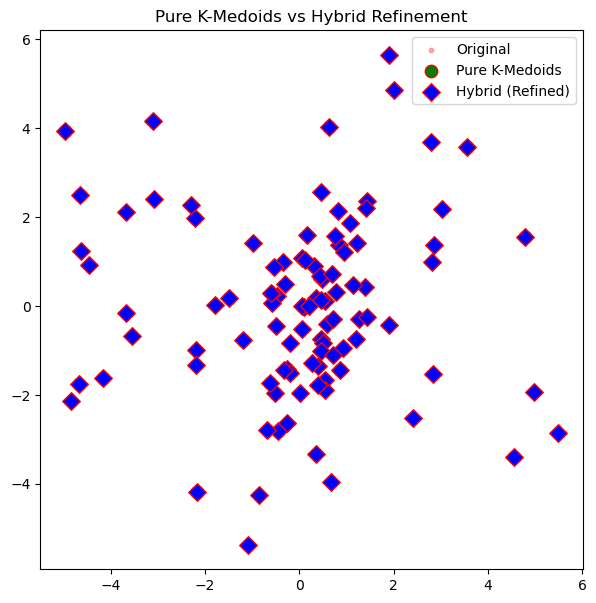

Pure: n=100, min=0.000, median=9.309, max=10.424
Hybrid: n=100, min=0.000, median=0.000, max=0.000


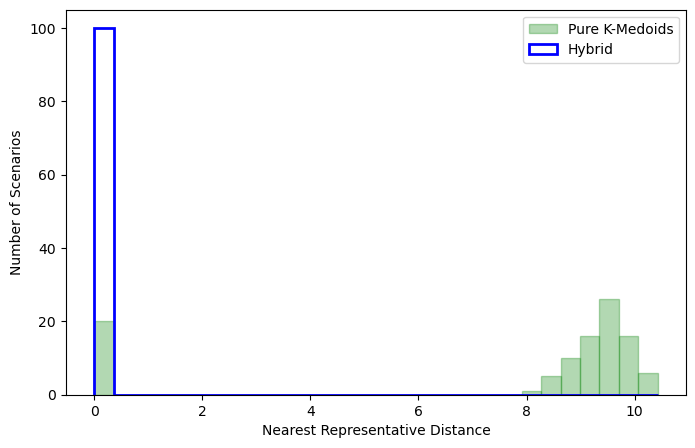

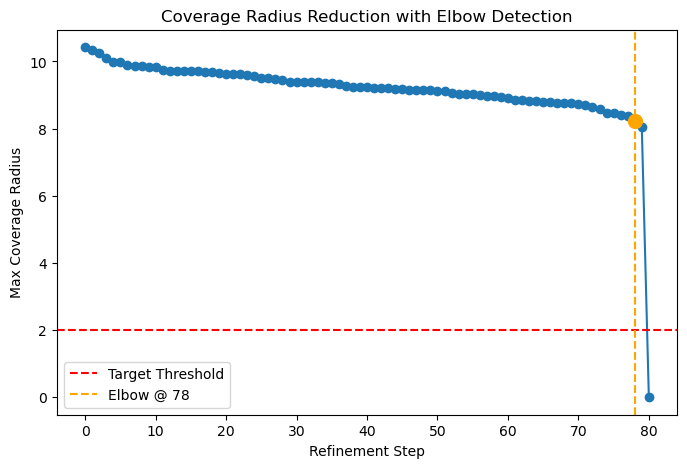

Elbow suggests threshold ≈ 8.241181843377499 at step 78 (total reps ≈ 98 )


In [5]:

# PCA scatter
pca = PCA(n_components=2)
pts_2d = pca.fit_transform(pts)
pure_2d = pca.transform(medoids)
hybrid_2d = pca.transform(hybrid_medoids)

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(pts_2d[:,0], pts_2d[:,1], c="red", s=10, alpha=0.3, label="Original")
ax.scatter(pure_2d[:,0], pure_2d[:,1], c="green", s=80, edgecolors="red", label="Pure K-Medoids")
ax.scatter(hybrid_2d[:,0], hybrid_2d[:,1], c="blue", s=80, edgecolors="red", marker="D", label="Hybrid (Refined)")
ax.set_title("Pure K-Medoids vs Hybrid Refinement")
ax.legend()
plt.show()

# Coverage histograms
p_pure = np.asarray(dmin_pure, dtype=float).squeeze().ravel()
p_hyb = np.asarray(dmin_hybrid, dtype=float).squeeze().ravel()
# Diagnostics
print(f"Pure: n={p_pure.size}, min={np.nanmin(p_pure):.3f}, median={np.nanmedian(p_pure):.3f}, max={np.nanmax(p_pure):.3f}")
print(f"Hybrid: n={p_hyb.size}, min={np.nanmin(p_hyb):.3f}, median={np.nanmedian(p_hyb):.3f}, max={np.nanmax(p_hyb):.3f}")
# Shared bins to make overlays comparable
xmin = np.nanmin([np.nanmin(p_pure), np.nanmin(p_hyb)])
xmax = np.nanmax([np.nanmax(p_pure), np.nanmax(p_hyb)])
bins = np.linspace(xmin, xmax, 30)
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(p_pure, bins=bins, alpha=0.3, label="Pure K-Medoids", color="green", edgecolor="green")
ax.hist(p_hyb, bins=bins, histtype="step", linewidth=2.0, label="Hybrid", color="blue")
ax.set_xlabel("Nearest Representative Distance")
ax.set_ylabel("Number of Scenarios")
ax.legend()
plt.show()

# Convergence + elbow
md = np.asarray(max_dists, dtype=float).squeeze().ravel()
elbow_idx, elbow_val = find_elbow(md)
plt.figure(figsize=(8,5))
plt.plot(md, marker="o")
plt.axhline(y=target_threshold, color="red", linestyle="--", label="Target Threshold")
plt.axvline(x=elbow_idx, color="orange", linestyle="--", label=f"Elbow @ {elbow_idx}")
plt.scatter(elbow_idx, elbow_val, c="orange", s=100, zorder=5)
plt.xlabel("Refinement Step")
plt.ylabel("Max Coverage Radius")
plt.title("Coverage Radius Reduction with Elbow Detection")
plt.legend()
plt.show()

print("Elbow suggests threshold ≈", elbow_val, "at step", elbow_idx, "(total reps ≈", k_init + elbow_idx, ")")


Added scenario 88, new max coverage radius = 10.3378
Added scenario 24, new max coverage radius = 10.2478
Added scenario 16, new max coverage radius = 10.1105
Added scenario 42, new max coverage radius = 9.9953
Added scenario 86, new max coverage radius = 9.9808
Added scenario 1, new max coverage radius = 9.9034
Added scenario 82, new max coverage radius = 9.8638
Added scenario 74, new max coverage radius = 9.8594
Added scenario 72, new max coverage radius = 9.8464
Added scenario 4, new max coverage radius = 9.8223
Added scenario 2, new max coverage radius = 9.7590
Added scenario 61, new max coverage radius = 9.7232
Added scenario 11, new max coverage radius = 9.7125
Added scenario 67, new max coverage radius = 9.7068
Added scenario 53, new max coverage radius = 9.7028
Added scenario 40, new max coverage radius = 9.7018
Added scenario 92, new max coverage radius = 9.6784
Added scenario 62, new max coverage radius = 9.6734
Added scenario 77, new max coverage radius = 9.6426
Added scenar

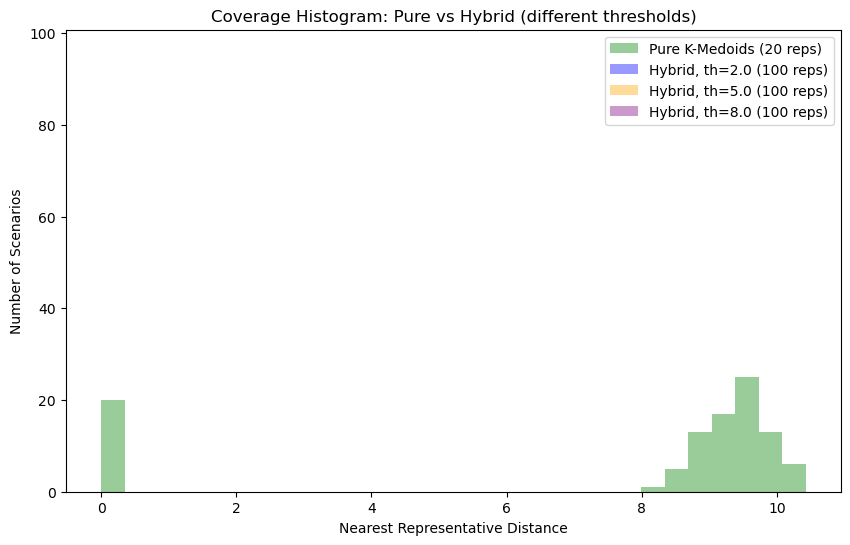

In [7]:
# Thresholds to test
thresholds = [2.0, 5.0, 8.0]

# Store results
results = {}

for th in thresholds:
    refined_indices, dmin_hybrid, max_dists = refine_until_threshold(pts, medoid_indices, threshold=th)
    results[th] = {
        "dmin": dmin_hybrid,
        "num_reps": len(refined_indices),
        "max_dists": max_dists
    }
    print(f"Threshold {th}: {len(refined_indices)} representatives, final max radius {dmin_hybrid.max():.3f}")

# Plot comparison histograms
plt.figure(figsize=(10,6))
plt.hist(dmin_pure, bins=30, alpha=0.4, label=f"Pure K-Medoids ({k_init} reps)", color="green")

colors = ["blue", "orange", "purple"]
for th, c in zip(thresholds, colors):
    plt.hist(results[th]["dmin"], bins=30, alpha=0.4, label=f"Hybrid, th={th} ({results[th]['num_reps']} reps)", color=c)

plt.xlabel("Nearest Representative Distance")
plt.ylabel("Number of Scenarios")
plt.title("Coverage Histogram: Pure vs Hybrid (different thresholds)")
plt.legend()
plt.show()


In [ ]:
# Build summary table for thresholds
summary_rows = []
for th, res in results.items():
    dmin = res["dmin"]
    summary_rows.append({
        "Threshold": th,
        "Num_Representatives": res["num_reps"],
        "Final_Max_Distance": float(dmin.max()),
        "Final_Mean_Distance": float(dmin.mean())
    })

summary_df = pd.DataFrame(summary_rows)
summary_df


,Threshold,Num_Representatives,Final_Max_Distance,Final_Mean_Distance
0,2.0,100,1.685874e-07,6.743496e-09
1,5.0,100,1.685874e-07,6.743496e-09
2,8.0,100,1.685874e-07,6.743496e-09
